# Explore and create ML datasets

In this notebook, we will explore data corresponding to taxi rides in New York City to build a Machine Learning model in support of a fare-estimation tool. The idea is to suggest a likely fare to taxi riders so that they are not surprised, and so that they can protest if the charge is much higher than expected.

## Learning Objectives
* Access and explore a public BigQuery dataset on NYC Taxi Cab rides
* Visualize your dataset using the Seaborn library
* Inspect and clean-up the dataset for future ML model training
* Create a benchmark to judge future ML model performance off of

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/01_explore_data.ipynb) -- try to complete that notebook first before reviewing this solution notebook. 

Let's start off with the Python imports that we need.

In [1]:
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil

<h3> Extract sample data from BigQuery </h3>

The dataset that we will use is <a href="https://console.cloud.google.com/bigquery?p=nyc-tlc&d=yellow&t=trips&page=table">a BigQuery public dataset</a>. Click on the link, and look at the column names. Switch to the Details tab to verify that the number of records is one billion, and then switch to the Preview tab to look at a few rows.

Let's write a SQL query to pick up interesting fields from the dataset. It's a good idea to get the timestamp in a predictable format.

In [2]:
%%bigquery
  SELECT
    FORMAT_TIMESTAMP("%Y-%m-%d %H:%M:%S %Z", pickup_datetime) AS pickup_datetime,
    pickup_longitude, pickup_latitude, dropoff_longitude,
    dropoff_latitude, passenger_count, trip_distance, tolls_amount, 
    fare_amount, total_amount 
  FROM `nyc-tlc.yellow.trips`
  LIMIT 10

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2010-02-08 09:17:00 UTC,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0.0
1,2010-02-23 13:00:19 UTC,-73.974440,40.754140,-73.782493,40.648832,1,17.6,0.0,0.0,0.0
2,2010-03-28 11:40:29 UTC,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0.0
3,2010-02-16 13:17:44 UTC,-73.995773,40.761368,-73.995773,40.761368,1,0.0,0.0,0.0,0.0
4,2010-03-16 01:04:50 UTC,-74.008316,40.736286,-74.008352,40.736250,1,0.0,0.0,0.0,0.0
5,2015-02-25 03:38:41 UTC,-73.937500,40.758198,-73.937523,40.758190,1,0.0,0.0,0.0,0.0
6,2015-04-17 16:43:09 UTC,-73.795265,40.666615,0.000000,0.000000,4,0.0,0.0,0.0,0.0
7,2015-03-19 08:57:55 UTC,-73.902100,40.764107,-73.902206,40.764126,6,0.0,0.0,0.0,0.0
8,2010-02-12 16:11:52 UTC,-73.955030,40.783350,-73.956183,40.782330,4,0.1,0.0,0.0,0.0
9,2015-05-08 07:59:51 UTC,-73.848007,40.723724,0.000000,0.000000,1,0.0,0.0,0.0,0.0


Let's increase the number of records so that we can do some neat graphs.  There is no guarantee about the order in which records are returned, and so no guarantee about which records get returned if we simply increase the LIMIT. To properly sample the dataset, let's use the HASH of the pickup time and return 1 in 100,000 records -- because there are 1 billion records in the data, we should get back approximately 10,000 records if we do this.

We will also store the BigQuery result in a Pandas dataframe named "trips"

In [3]:
%%bigquery trips
  SELECT
    FORMAT_TIMESTAMP("%Y-%m-%d %H:%M:%S %Z", pickup_datetime) AS pickup_datetime,
    pickup_longitude, pickup_latitude, 
    dropoff_longitude, dropoff_latitude,
    passenger_count,
    trip_distance,
    tolls_amount,
    fare_amount,
    total_amount
  FROM
    `nyc-tlc.yellow.trips`
  WHERE
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1

In [4]:
print(len(trips))

10789


In [5]:
# We can slice Pandas dataframes as if they were arrays
trips[:10]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2014-05-17 15:15:00 UTC,-73.980682,40.734032,-73.961948,40.755545,1,2.20,0.0,22.5,23.00
1,2009-11-01 02:59:23 UTC,-74.006934,40.734067,-73.895708,40.851511,4,12.10,0.0,28.5,29.50
2,2014-05-17 15:15:00 UTC,-73.991745,40.749897,-74.014913,40.709987,1,4.44,0.0,22.0,26.90
3,2014-07-11 15:47:07 UTC,-73.975224,40.757659,-73.997157,40.714348,2,4.70,0.0,19.5,22.00
4,2009-05-28 13:14:08 UTC,-73.978569,40.751850,-74.004371,40.710045,1,4.80,0.0,15.7,15.70
5,2011-09-19 15:43:52 UTC,-73.872708,40.774221,-73.983089,40.764476,1,10.90,4.8,31.3,43.92
6,2013-04-18 08:48:00 UTC,-73.973102,40.785075,-74.011462,40.708307,1,6.79,0.0,29.0,32.00
7,2009-11-05 06:47:00 UTC,-73.980313,40.744282,-74.015285,40.711458,1,5.55,0.0,14.9,18.38
8,2009-03-28 20:30:35 UTC,-73.973926,40.757725,-73.981695,40.761591,1,0.50,0.0,4.6,4.60
9,2009-08-23 23:59:22 UTC,-73.783319,40.648480,-73.893649,40.646566,1,8.30,0.0,18.9,18.90


<h3> Exploring data </h3>

Let's explore this dataset and clean it up as necessary. We'll use the Python Seaborn package to visualize graphs and Pandas to do the slicing and filtering.

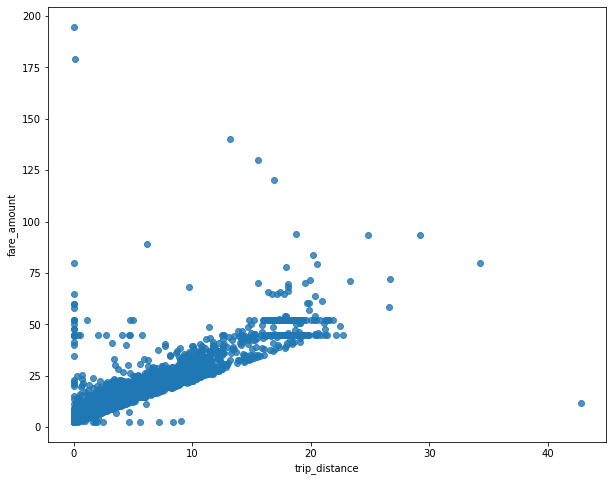

In [6]:
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)
ax.figure.set_size_inches(10, 8)

Hmm ... do you see something wrong with the data that needs addressing?

It appears that we have a lot of invalid data that is being coded as zero distance and some fare amounts that are definitely illegitimate. Let's remove them from our analysis. We can do this by modifying the BigQuery query to keep only trips longer than zero miles and fare amounts that are at least the minimum cab fare ($2.50).

Note the extra WHERE clauses.

In [7]:
%%bigquery trips
  SELECT
    FORMAT_TIMESTAMP("%Y-%m-%d %H:%M:%S %Z", pickup_datetime) AS pickup_datetime,
    pickup_longitude, pickup_latitude, 
    dropoff_longitude, dropoff_latitude,
    passenger_count,
    trip_distance,
    tolls_amount,
    fare_amount,
    total_amount
  FROM
    `nyc-tlc.yellow.trips`
  WHERE
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1
    AND trip_distance > 0 AND fare_amount >= 2.5

In [8]:
print(len(trips))

10716


Text(0.5, 1.0, 'Going for a Ride: Fare Versus Distance in NYC Taxis')

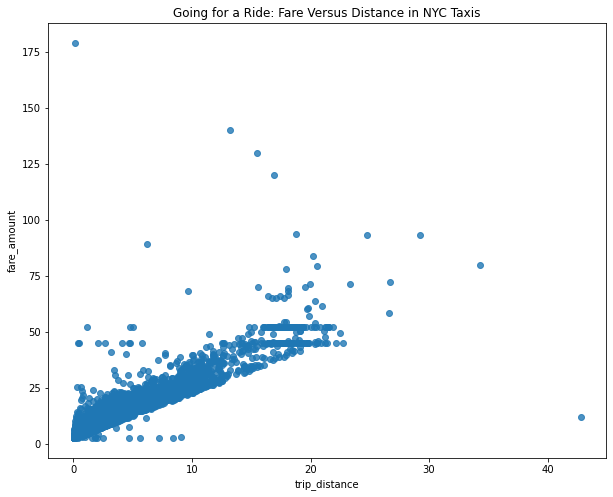

In [9]:
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)
ax.figure.set_size_inches(10, 8)
ax.set_title("Going for a Ride: Fare Versus Distance in NYC Taxis")

What's up with the streaks around 45 dollars and 50 dollars?  Those are fixed-amount rides from JFK and La Guardia airports into anywhere in Manhattan, i.e. to be expected. Let's list the data to make sure the values look reasonable.

Let's also examine whether the toll amount is captured in the total amount.

In [10]:
tollrides = trips[trips['tolls_amount'] > 0]
tollrides[tollrides['pickup_datetime'] == '2012-02-27 09:19:10 UTC']

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
51,2012-02-27 09:19:10 UTC,-73.874431,40.774011,-73.983967,40.744082,1,11.6,4.8,27.7,38.0


Looking a few samples above, it should be clear that the total amount reflects fare amount, toll and tip somewhat arbitrarily -- this is because when customers pay cash, the tip is not known.  So, we'll use the sum of fare_amount + tolls_amount as what needs to be predicted.  Tips are discretionary and do not have to be included in our fare estimation tool.  Of course some cab drivers may feel they are discretionsary!

Let's also look at the distribution of values within the columns.

In [11]:
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000
mean,-72.602192,40.002372,-72.594838,40.002052,1.650056,2.856395,0.226428,11.109446,13.217078
std,9.982373,5.474670,10.004324,5.474648,1.283577,3.322024,1.135934,9.137710,10.953156
min,-74.258183,0.000000,-74.260472,0.000000,0.000000,0.010000,0.000000,2.500000,2.500000
25%,-73.992153,40.735936,-73.991566,40.734310,1.000000,1.040000,0.000000,6.000000,7.300000
50%,-73.981851,40.753264,-73.980373,40.752956,1.000000,1.770000,0.000000,8.500000,10.000000
75%,-73.967400,40.767340,-73.964142,40.767510,2.000000,3.160000,0.000000,12.500000,14.600000
max,0.000000,41.366138,0.000000,41.366138,6.000000,42.800000,16.000000,179.000000,179.000000


Hmm ... The min, max of longitude look strange.

Finally, let's actually look at the start and end of a few of the trips.

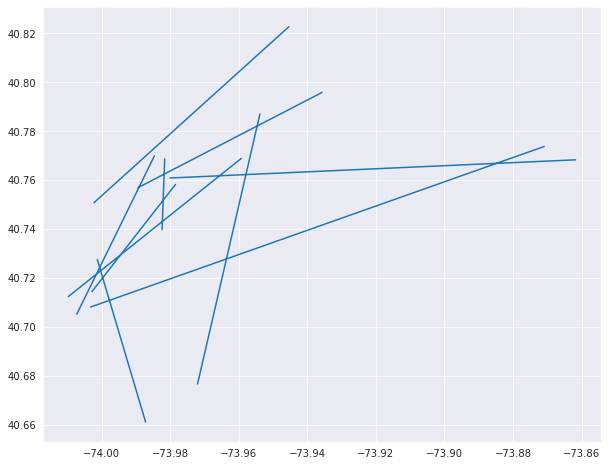

In [12]:
def showrides(df, numlines):
  lats = []
  lons = []
  for iter, row in df[:numlines].iterrows():
    lons.append(row['pickup_longitude'])
    lons.append(row['dropoff_longitude'])
    lons.append(None)
    lats.append(row['pickup_latitude'])
    lats.append(row['dropoff_latitude'])
    lats.append(None)

  sns.set_style("darkgrid")
  plt.figure(figsize=(10,8))
  plt.plot(lons, lats)

showrides(trips, 10)

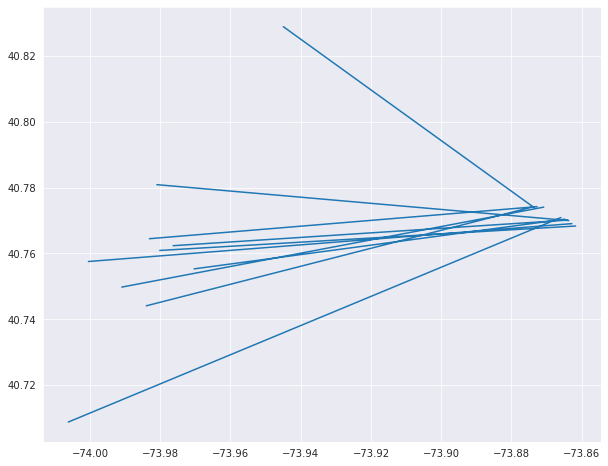

In [13]:
showrides(tollrides, 10)

As you'd expect, rides that involve a toll are longer than the typical ride.

<h3> Quality control and other preprocessing </h3>

We need to do some clean-up of the data:
<ol>
<li>New York city longitudes are around -74 and latitudes are around 41.</li>
<li>We shouldn't have zero passengers.</li>
<li>Clean up the total_amount column to reflect only fare_amount and tolls_amount, and then remove those two columns.</li>
<li>Before the ride starts, we'll know the pickup and dropoff locations, but not the trip distance (that depends on the route taken), so remove it from the ML dataset</li>
<li>Discard the timestamp</li>
</ol>

We could do preprocessing in BigQuery, similar to how we removed the zero-distance rides, but just to show you another option, let's do this in Python.  In production, we'll have to carry out the same preprocessing on the real-time input data. 

This sort of preprocessing of input data is quite common in ML, especially if the quality-control is dynamic.

In [14]:
def preprocess(trips_in):
  trips = trips_in.copy(deep=True)
  trips.fare_amount = trips.fare_amount + trips.tolls_amount
  del trips['tolls_amount']
  del trips['total_amount']
  del trips['trip_distance'] # we won't know this in advance!

  qc = np.all([\
             trips['pickup_longitude'] > -78, \
             trips['pickup_longitude'] < -70, \
             trips['dropoff_longitude'] > -78, \
             trips['dropoff_longitude'] < -70, \
             trips['pickup_latitude'] > 37, \
             trips['pickup_latitude'] < 45, \
             trips['dropoff_latitude'] > 37, \
             trips['dropoff_latitude'] < 45, \
             trips['passenger_count'] > 0,
            ], axis=0)
  return trips[qc]

tripsqc = preprocess(trips)
tripsqc.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000
mean,-73.975206,40.751526,-73.974373,40.751199,1.653303,11.349003
std,0.038547,0.029187,0.039086,0.033147,1.278827,9.878630
min,-74.258183,40.452290,-74.260472,40.417750,1.000000,2.500000
25%,-73.992336,40.737600,-73.991739,40.735904,1.000000,6.000000
50%,-73.982090,40.754020,-73.980780,40.753597,1.000000,8.500000
75%,-73.968517,40.767774,-73.965851,40.767921,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,179.000000


The quality control has removed about 300 rows (11400 - 11101) or about 3% of the data. This seems reasonable.

Let's move on to creating the ML datasets.

<h3> Create ML datasets </h3>

Let's split the QCed data randomly into training, validation and test sets.
Note that this is not the entire data. We have 1 billion taxicab rides. This is just splitting the 10,000 rides to show you how it's done on smaller datasets. In reality, we'll have to do it on all 1 billion rides and this won't scale.

In [15]:
shuffled = tripsqc.sample(frac=1)
trainsize = int(len(shuffled['fare_amount']) * 0.70)
validsize = int(len(shuffled['fare_amount']) * 0.15)

df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]
df_test = shuffled.iloc[(trainsize+validsize):, :]

In [16]:
df_train.head(n=1)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
6591,2014-10-06 15:16:00 UTC,-73.961627,40.76014,-73.961627,40.76014,6,16.5


In [17]:
df_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,7333.000000,7333.000000,7333.000000,7333.000000,7333.000000,7333.000000
mean,-73.974975,40.751591,-73.974350,40.751279,1.661803,11.338428
std,0.040418,0.030483,0.039115,0.033416,1.291484,9.888360
min,-74.258183,40.452290,-74.260472,40.417750,1.000000,2.500000
25%,-73.992484,40.737579,-73.991688,40.735605,1.000000,6.000000
50%,-73.982062,40.754262,-73.980828,40.753837,1.000000,8.500000
75%,-73.968125,40.767797,-73.965416,40.768046,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,179.000000


In [18]:
df_valid.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000
mean,-73.975498,40.751281,-73.976277,40.749721,1.666454,11.295958
std,0.034520,0.026151,0.033130,0.029664,1.265219,9.612576
min,-74.017850,40.641542,-74.182503,40.561076,1.000000,2.500000
25%,-73.991861,40.737972,-73.992757,40.735245,1.000000,6.000000
50%,-73.982597,40.753172,-73.981272,40.752387,1.000000,8.500000
75%,-73.969779,40.767769,-73.967766,40.765990,2.000000,12.500000
max,-73.776709,40.847460,-73.746183,40.867001,6.000000,90.500000


In [19]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000
mean,-73.975995,40.751465,-73.972579,40.752303,1.600509,11.451349
std,0.033040,0.025690,0.044068,0.035100,1.231643,10.098638
min,-74.017970,40.640840,-74.182062,40.618532,1.000000,2.900000
25%,-73.992099,40.737371,-73.991307,40.737354,1.000000,6.000000
50%,-73.981811,40.753999,-73.980267,40.754108,1.000000,8.500000
75%,-73.968990,40.767553,-73.964859,40.768832,2.000000,12.500000
max,-73.695303,40.865671,-73.137393,41.366138,6.000000,99.300000


Let's write out the three dataframes to appropriately named csv files. We can use these csv files for local training (recall that these files represent only 1/100,000 of the full dataset) just to verify our code works, before we run it on all the data.

In [20]:
def to_csv(df, filename):
  outdf = df.copy(deep=False)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # reorder columns so that target is first column
  cols = outdf.columns.tolist()
  cols.remove('fare_amount')
  cols.insert(0, 'fare_amount')
  print (cols)  # new order of columns
  outdf = outdf[cols]
  outdf.to_csv(filename, header=False, index_label=False, index=False)

to_csv(df_train, 'taxi-train.csv')
to_csv(df_valid, 'taxi-valid.csv')
to_csv(df_test, 'taxi-test.csv')

['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']
['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']
['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']


In [21]:
!head -10 taxi-valid.csv

8.0,2015-05-16 02:01:03 UTC,-73.97833251953125,40.78310775756836,-73.95404815673828,40.78716278076172,2,0
13.5,2014-05-17 15:15:00 UTC,-74.016417,40.710252,-73.994697,40.75038,2,1
4.0,2015-05-11 20:54:47 UTC,-73.97235107421875,40.79430389404297,-73.97289276123047,40.79844665527344,1,2
6.9,2009-12-07 20:49:00 UTC,-73.955477,40.78544,-73.974972,40.777682,1,3
12.5,2015-06-17 07:49:33 UTC,-73.9571762084961,40.77756881713867,-73.97979736328125,40.75950241088867,1,4
5.7,2009-12-01 15:30:14 UTC,-73.97421,40.764594,-73.983469,40.757076,2,5
8.0,2014-03-06 06:46:59 UTC,-73.972894,40.762513,-73.953548,40.788014,1,6
10.1,2010-04-29 12:28:00 UTC,-73.997135,40.73701,-73.997467,40.737328,1,7
5.7,2009-11-21 08:52:32 UTC,-73.954553,40.786866,-73.971305,40.791905,2,8
9.5,2014-12-08 21:50:00 UTC,-73.99725,40.7212,-73.9916,40.7438,1,9


<h3> Verify that datasets exist </h3>

In [22]:
!ls -l *.csv

-rw-r--r-- 1 jupyter jupyter 122888 Apr  1 07:44 taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579931 Apr  1 07:44 taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 122940 Apr  1 07:44 taxi-valid.csv


We have 3 .csv files corresponding to train, valid, test.  The ratio of file-sizes correspond to our split of the data.

In [23]:
%%bash
head taxi-train.csv

16.5,2014-10-06 15:16:00 UTC,-73.961627,40.76014,-73.961627,40.76014,6,0
12.1,2012-03-04 00:57:00 UTC,-73.941525,40.798698,-73.98975,40.762308,1,1
5.8,2009-02-24 23:44:22 UTC,-73.986531,40.757109,-73.97403,40.750545,4,2
8.1,2012-02-21 11:53:00 UTC,-73.971538,40.797177,-73.97251,40.781032,1,3
6.5,2010-12-21 11:24:35 UTC,-73.985302,40.723736,-73.996623,40.718851,2,4
9.0,2013-04-18 08:48:00 UTC,-73.985625,40.761122,-74.004637,40.707275,1,5
8.1,2010-09-26 10:01:50 UTC,-73.981373,40.728984,-73.99197,40.750038,3,6
10.0,2014-10-06 15:16:00 UTC,-73.954258,40.786935,-73.962435,40.768822,5,7
30.9,2010-04-08 15:08:17 UTC,-73.972373,40.7811,-73.985989,40.757344,4,8
13.5,2013-04-18 08:48:00 UTC,-73.991623,40.749937,-73.979638,40.781245,1,9


Looks good! We now have our ML datasets and are ready to train ML models, validate them and evaluate them.

<h3> Benchmark </h3>

Before we start building complex ML models, it is a good idea to come up with a very simple model and use that as a benchmark.

Our model is going to be to simply divide the mean fare_amount by the mean trip_distance to come up with a rate and use that to predict.  Let's compute the RMSE of such a model. We will use the [Haversine](https://en.wikipedia.org/wiki/Haversine_formula) formula.

In [24]:
def distance_between(lat1, lon1, lat2, lon2):
  # haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
  dist = np.degrees(np.arccos(np.minimum(1,np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1))))) * 60 * 1.515 * 1.609344
  return dist

def estimate_distance(df):
  return distance_between(df['pickuplat'], df['pickuplon'], df['dropofflat'], df['dropofflon'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual-predicted)**2))

def print_rmse(df, rate, name):
  print ("{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate*estimate_distance(df)), name))

FEATURES = ['pickuplon','pickuplat','dropofflon','dropofflat','passengers']
TARGET = 'fare_amount'
columns = list([TARGET])
columns.append('pickup_datetime')
columns.extend(FEATURES) # in CSV, target is the first column, after the features
columns.append('key')
df_train = pd.read_csv('taxi-train.csv', header=None, names=columns)
df_valid = pd.read_csv('taxi-valid.csv', header=None, names=columns)
df_test = pd.read_csv('taxi-test.csv', header=None, names=columns)
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print ("Rate = ${0}/km".format(rate))
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid') 
print_rmse(df_test, rate, 'Test') 

Rate = $2.581473953775117/km
Train RMSE = 7.308176385544027
Valid RMSE = 6.37694086596928
Test RMSE = 9.465354234265918


<h2>Benchmark on same dataset</h2>

The RMSE depends on the dataset, and for comparison, we have to evaluate on the same dataset each time. We'll use this query in later labs:

In [25]:
validation_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_datetime,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  'unused' AS key
FROM `nyc-tlc.yellow.trips`
WHERE ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 10000)) = 2
AND
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """

client = bigquery.Client()
df_valid = client.query(validation_query).to_dataframe()
print_rmse(df_valid, 2.59988, 'Final Validation Set')

Final Validation Set RMSE = 8.135336354024929


The simple distance-based rule gives us a RMSE of <b>$8.14</b>.  We have to beat this, of course, but you will find that simple rules of thumb like this can be surprisingly difficult to beat.

Let's be ambitious, though, and make our goal to build ML models that have a RMSE of less than $6 on the test set.

Copyright 2020 Afinepoint Inc.
Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.